# Multivariate Example
This notebook outlines an example of scalecast using multiple series to forecast one another. The following concepts are covered:  
1. Exploratory Data Analysis  
2. Univariate modeling with `auto_forecast()`  
3. combination modeling  
4. Plotting test set  
5. Exporting model statistics  
6. Plotting feature importances  
7. Building the `MVForecaster` object from scalecast  
8. Multivariate modeling with `auto_forecast()`  
9. Importing a new sklearn model (`StackingRegressor`) for multivariate combination modeling  

The data is available on Kaggle: https://www.kaggle.com/datasets/neuromusic/avocado-prices

In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm as log_progress
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator

sns.set(rc={'figure.figsize':(12,8)})

In [2]:
# read data
data = pd.read_csv('avocado.csv',parse_dates=['Date']).sort_values(['Date'])
# sort appropriately (not doing this could cause issues)
data = data.sort_values(['region','type','Date'])

We will be forecasting the organic and conventional avocado sales from California only.

In [3]:
data_cali = data.loc[data['region'] == 'California']
data_cali_org = data_cali.loc[data_cali['type'] == 'organic']
data_cali_con = data_cali.loc[data_cali['type'] == 'conventional']

## Choose Models and Import Validation Grids

In [4]:
# download template validation grids (will not overwrite existing Grids.py file by default)
models = ('mlr','elasticnet','knn','rf','gbt','xgboost','mlp')
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

## EDA

### Plot

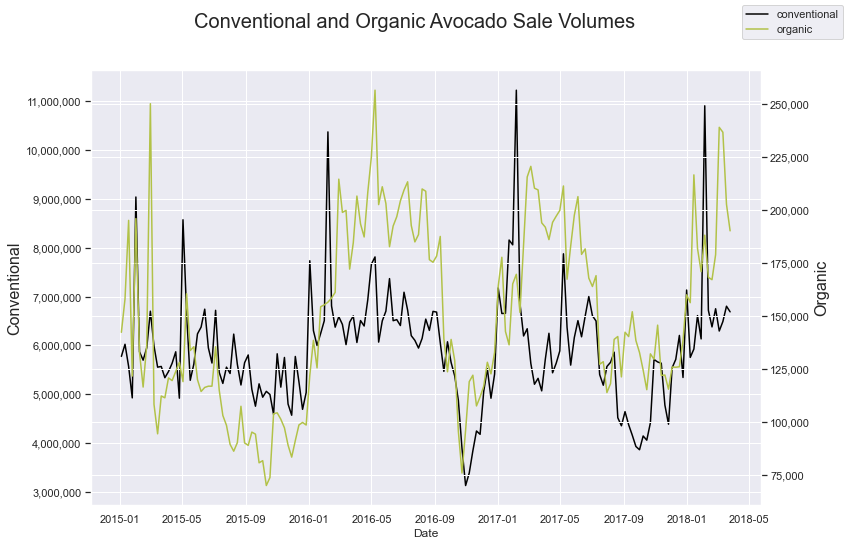

In [5]:
fig, ax = plt.subplots()
sns.lineplot(x='Date',y='Total Volume',data=data_cali_con,label='conventional',ax=ax,color='black',legend=False)
plt.ylabel('Conventional',size=16)
ax2 = ax.twinx()
sns.lineplot(x='Date',y='Total Volume',data=data_cali_org,label='organic',ax=ax2,color='#B2C248',legend=False)
ax.figure.legend()
plt.ylabel('Organic',size=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.suptitle('Conventional and Organic Avocado Sale Volumes',size=20)
plt.show()

### Examine Correlation between the series

In [6]:
corr = np.corrcoef(data_cali_org['Total Volume'].values,data_cali_con['Total Volume'].values)[0,1]
print('{:.2%}'.format(corr))

48.02%


### Load into Forecaster from scalecast

In [7]:
fcon = Forecaster(y=data_cali_con['Total Volume'],current_dates = data_cali_con['Date'])
fcon

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

In [8]:
forg = Forecaster(y=data_cali_org['Total Volume'],current_dates = data_cali_org['Date'])
forg

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

### ACF and PACF Plots

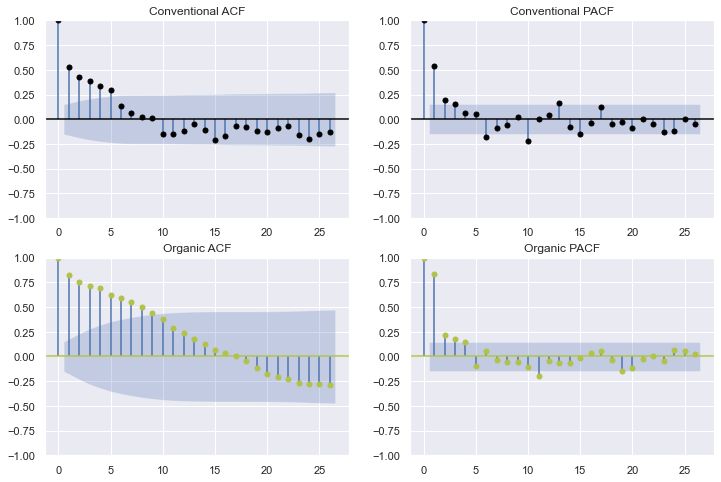

In [9]:
figs, axs = plt.subplots(2, 2)
fcon.plot_acf(ax=axs[0,0],title='Conventional ACF',lags=26,color='black')
fcon.plot_pacf(ax=axs[0,1],title='Conventional PACF',lags=26,color='black')
forg.plot_acf(ax=axs[1,0],title='Organic ACF',lags=26,color='#B2C248')
forg.plot_pacf(ax=axs[1,1],title='Organic PACF',lags=26,color='#B2C248')
plt.show()

### Seasonal Decomposition Plots

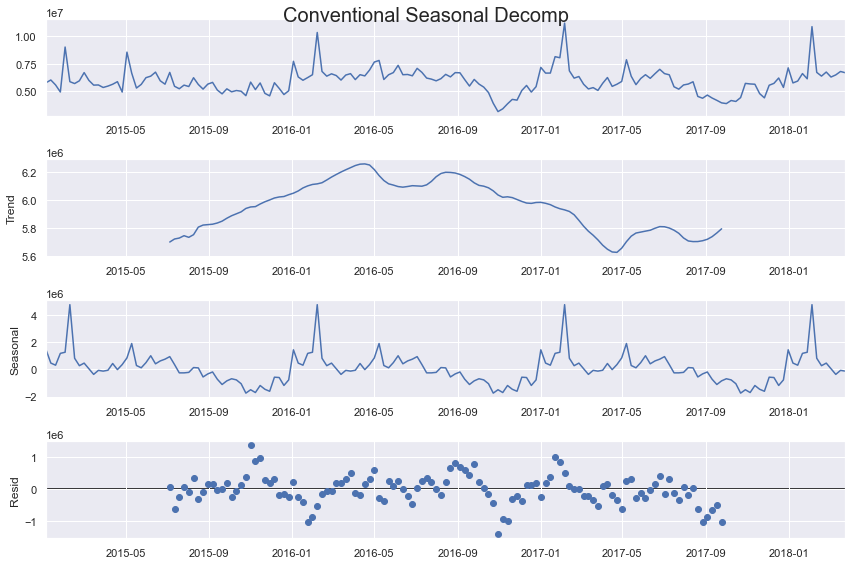

In [10]:
fcon.seasonal_decompose().plot()
plt.suptitle('Conventional Seasonal Decomp',size=20)
plt.show()

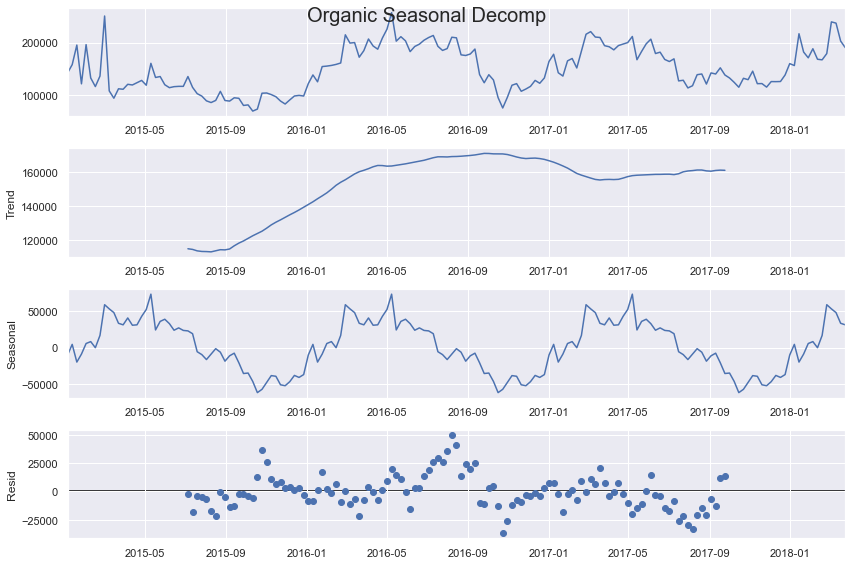

In [11]:
forg.seasonal_decompose().plot()
plt.suptitle('Organic Seasonal Decomp',size=20)
plt.show()

### Check Stationarity

In [12]:
critical_pval = 0.05
print('-'*100)
print('Conventional Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = fcon.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)
print('Organic Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = forg.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Conventional Augmented Dickey-Fuller results:
the test-stat value is: -3.35
the p-value is 0.0128
the series is stationary
----------------------------------------------------------------------------------------------------
Organic Augmented Dickey-Fuller results:
the test-stat value is: -2.94
the p-value is 0.0404
the series is stationary
----------------------------------------------------------------------------------------------------


## Scalecast - Univariate

### Load Objects with parameters:
- Forecast horizon (52 weeks)
- Test length (20%)
- Validation length (4 periods)
- Seasonal regressor (week, month, quarter)
- Irregular Cycle (26 weeks)
- Dep Var Lags (3)

In [13]:
for f in (fcon,forg):
    f.generate_future_dates(52)
    f.set_test_length(.2)
    f.set_validation_length(4)
    f.add_seasonal_regressors('week','month','quarter',raw=False,sincos=True)
    f.add_seasonal_regressors('year')
    f.add_time_trend()
    f.add_cycle(26)
    f.add_ar_terms(3)

### Tune and Forecast with Selected Models

#### Conventional

In [14]:
fcon.tune_test_forecast(models,feature_importance=True)
fcon.set_estimator('combo')
fcon.manual_forecast(how='weighted')

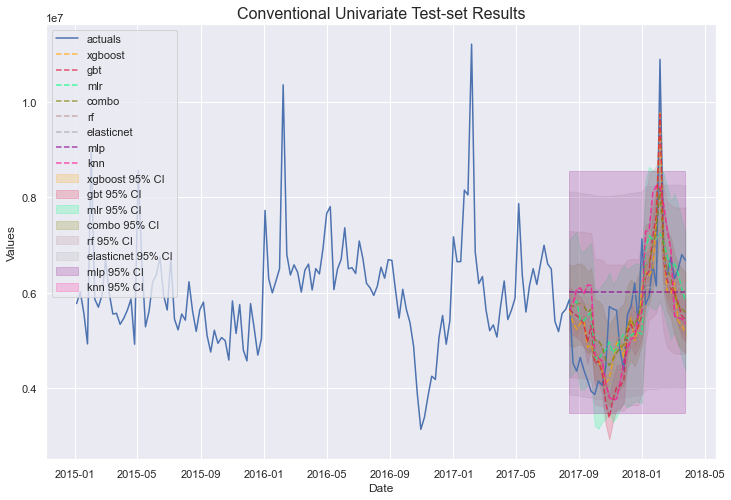

In [15]:
fcon.plot_test_set(ci=True,order_by='LevelTestSetMAPE')
plt.title('Conventional Univariate Test-set Results',size=16)
plt.show()

#### Organic

In [16]:
forg.tune_test_forecast(models,feature_importance=True)
fcon.set_estimator('combo')
fcon.manual_forecast(how='weighted')

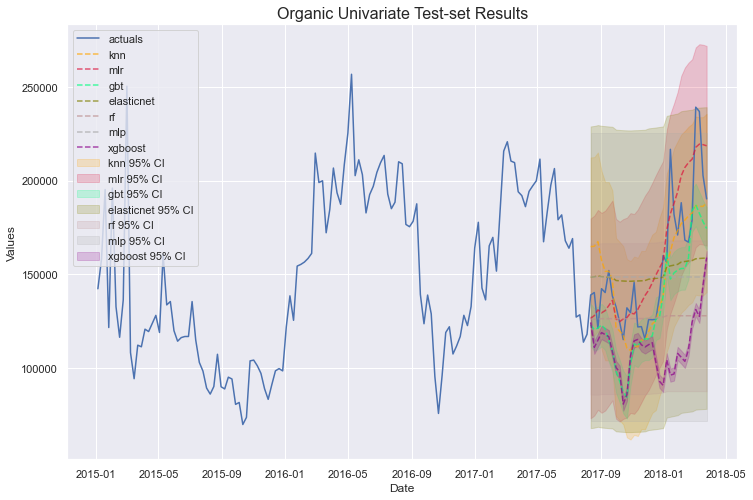

In [17]:
forg.plot_test_set(ci=True,order_by='LevelTestSetMAPE')
plt.title('Organic Univariate Test-set Results',size=16)
plt.show()

### Feature Importance
By default, scalecast uses permutation feature importance from ELI5. After calling a model, the model object from sklearn is available using `f.regr` and that object can be used to export other types of feature importances.

#### Conventional
- Best model: xgboost

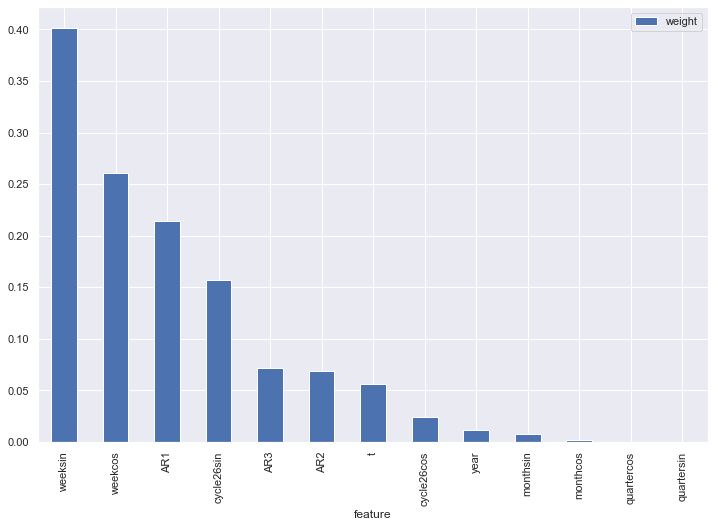

In [18]:
fcon.export_feature_importance('xgboost').plot.bar(y='weight')
plt.show()

#### Organic
- Best model: knn

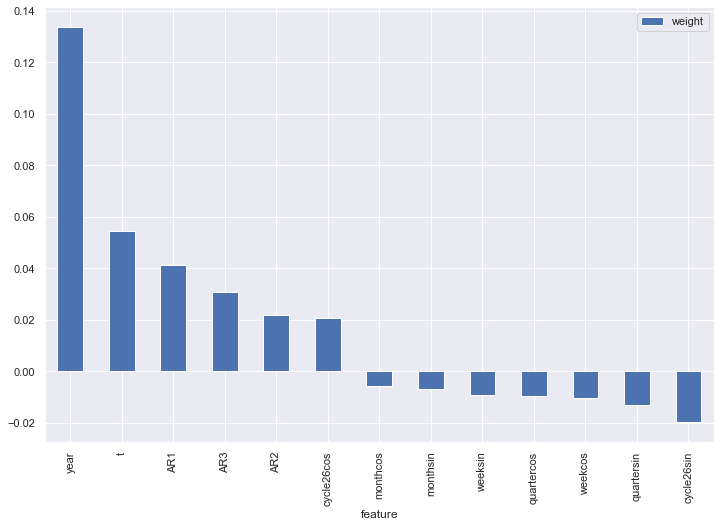

In [19]:
forg.export_feature_importance('knn').plot.bar(y='weight')
plt.show()

### Model Summaries

In [20]:
pd.set_option('display.float_format',  '{:.4f}'.format)
ms = export_model_summaries({'Conventional':fcon,'Organic':forg},determine_best_by='LevelTestSetMAPE')
ms[
    [
        'ModelNickname',
        'Series',
        'Integration',
        'LevelTestSetMAPE',
        'LevelTestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'best_model'
    ]
]

,ModelNickname,Series,Integration,LevelTestSetMAPE,LevelTestSetR2,InSampleMAPE,InSampleR2,best_model
0,xgboost,Conventional,0,0.1257,0.6268,0.0092,0.9964,True
1,gbt,Conventional,0,0.1525,0.4536,0.0328,0.9597,False
2,mlr,Conventional,0,0.1554,0.3536,0.1008,0.4582,False
3,combo,Conventional,0,0.1572,0.4327,0.0477,0.8914,False
4,rf,Conventional,0,0.1585,0.3620,0.0893,0.5706,False
5,elasticnet,Conventional,0,0.1898,0.0123,0.1349,0.1023,False
6,mlp,Conventional,0,0.2030,-0.0797,0.1457,-0.0000,False
7,knn,Conventional,0,0.2166,-0.0105,0.0000,1.0000,False
8,knn,Organic,0,0.0962,0.5727,0.1315,0.7072,True
9,mlr,Organic,0,0.1032,0.6736,0.1005,0.7570,False


Because running so many models can cause overfitting on the test set, we can check the average test error between all models to get another metric of how effective our modeling process is.

In [21]:
print('-'*100)
for series in ms['Series'].unique():
    print('univariate average test MAPE for {}: {:.4f}'.format(series,ms.loc[ms['Series'] == series,'LevelTestSetMAPE'].mean()))
    print('univariate average test R2 for {}: {:.2f}'.format(series,ms.loc[ms['Series'] == series,'LevelTestSetR2'].mean()))
    print('-'*100)

----------------------------------------------------------------------------------------------------
univariate average test MAPE for Conventional: 0.1698
univariate average test R2 for Conventional: 0.27
----------------------------------------------------------------------------------------------------
univariate average test MAPE for Organic: 0.1525
univariate average test R2 for Organic: -0.05
----------------------------------------------------------------------------------------------------


These are interesting error metrics, but a lot of models, including XGBoost and GBT appear to be overfitting. Let's see if we can beat the results with a multivariate approach.

## Scalecast - Multivariate

### Set MV Parameters
- Forecast horizon already set
- Xvars already set
- Test size must be set: 20%
- Validation size must be set: 4 periods

In [22]:
mvf = MVForecaster(fcon,forg,names=['Conventional','Organic']) # init the mvf object
mvf.set_test_length(.2)
mvf.set_validation_length(4)

### Set Optimize On
- If predicting one series is more important than predicting the other, you can use this code to let the code know to favor one over the other
- By default, it uses the mean error metrics between all series

In [23]:
# how to optimize on one series
mvf.set_optimize_on('Organic')
# how to optimize on the average of both/all series
mvf.set_optimize_on('mean')

### Tune and Test with Selected Models

In [24]:
mvf.tune_test_forecast(models)
mvf.set_best_model(determine_best_by='LevelTestSetMAPE')

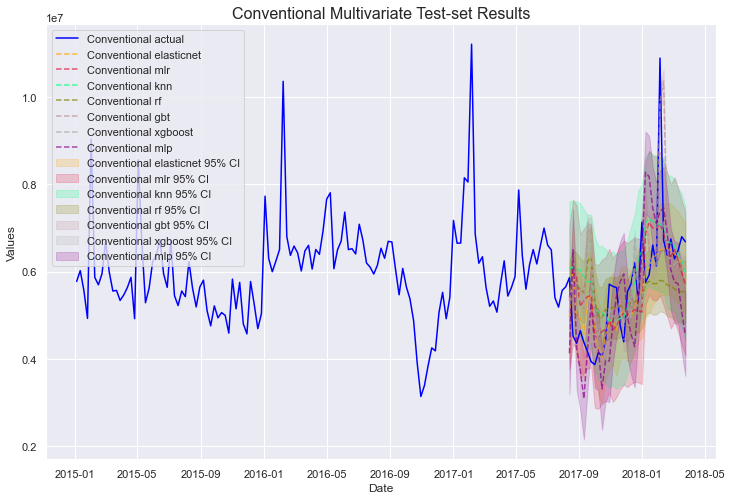

In [25]:
# not plotting both series at the same time because they have significantly different scales
mvf.plot_test_set(series='Conventional',put_best_on_top=True,ci=True)
plt.title('Conventional Multivariate Test-set Results',size=16)
plt.show()

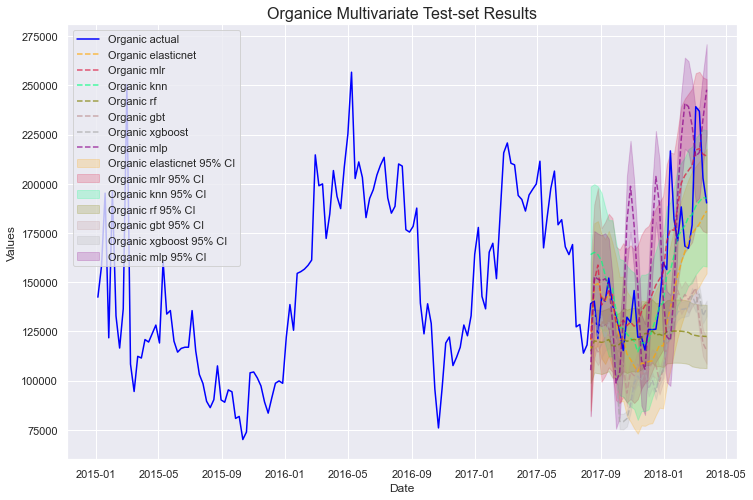

In [26]:
mvf.plot_test_set(series='Organic',put_best_on_top=True,ci=True)
plt.title('Organice Multivariate Test-set Results',size=16)
plt.show()

### Export Model Summaries

In [27]:
pd.options.display.max_colwidth = 100
results = mvf.export_model_summaries()
results[
    [
        'ModelNickname',
        'Series',
        'HyperParams',
        'LevelTestSetMAPE',
        'LevelTestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'Lags'
    ]
]

,ModelNickname,Series,HyperParams,LevelTestSetMAPE,LevelTestSetR2,InSampleMAPE,InSampleR2,Lags
0,elasticnet,Conventional,"{'alpha': 0.5, 'l1_ratio': 0.75}",0.1168,0.4077,0.0832,0.6262,13
1,mlr,Conventional,{},0.1518,0.3402,0.0992,0.4793,3
2,knn,Conventional,"{'n_neighbors': 17, 'weights': 'uniform'}",0.1711,0.2682,0.0985,0.5246,13
3,rf,Conventional,"{'max_depth': 5, 'n_estimators': 500}",0.1805,0.0180,0.0476,0.9031,10
4,gbt,Conventional,"{'max_depth': 3, 'max_features': None}",0.1644,0.1984,0.0195,0.9862,10
5,xgboost,Conventional,{'max_depth': 2},0.1515,0.2215,0.0101,0.9960,13
6,mlp,Conventional,"{'activation': 'relu', 'hidden_layer_sizes': (25, 25), 'solver': 'lbfgs', 'random_state': 20}",0.1899,-0.0016,0.0712,0.8127,10
7,elasticnet,Organic,"{'alpha': 0.5, 'l1_ratio': 0.75}",0.1185,0.3488,0.0843,0.8679,13
8,mlr,Organic,{},0.1011,0.6751,0.1010,0.7648,3
9,knn,Organic,"{'n_neighbors': 17, 'weights': 'uniform'}",0.0889,0.6098,0.0947,0.8214,13


### Import a Foreign Sklearn Estimator for Ensemble Modeling

In [28]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
estimators = [
    ('mlr',LinearRegression()),
    ('elasticnet',ElasticNet(**results.loc[results['ModelNickname'] == 'elasticnet','HyperParams'].values[0])),
    ('mlp',MLPRegressor(**results.loc[results['ModelNickname'] == 'mlp','HyperParams'].values[0]))
]

final_estimator = KNeighborsRegressor(**results.loc[results['ModelNickname'] == 'knn','HyperParams'].values[0])

In [29]:
mvf.add_sklearn_estimator(StackingRegressor,'stacking')
mvf.set_estimator('stacking')
mvf.manual_forecast(estimators=estimators,final_estimator=final_estimator,lags=13)

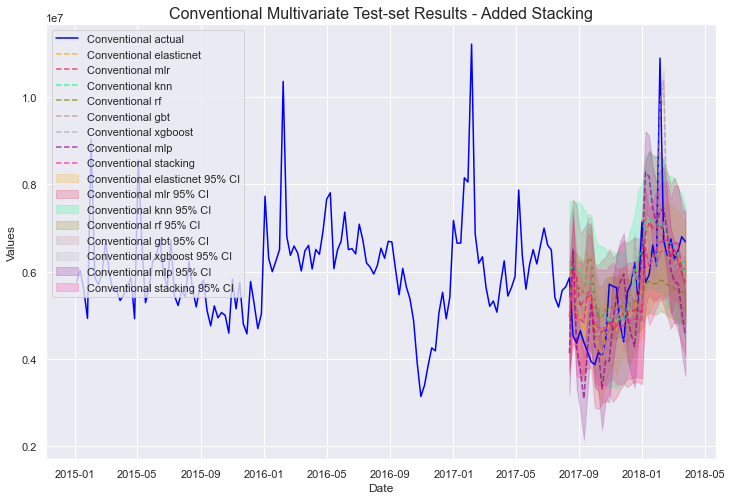

In [30]:
mvf.plot_test_set(series='Conventional',put_best_on_top=True,ci=True)
plt.title('Conventional Multivariate Test-set Results - Added Stacking',size=16)
plt.show()

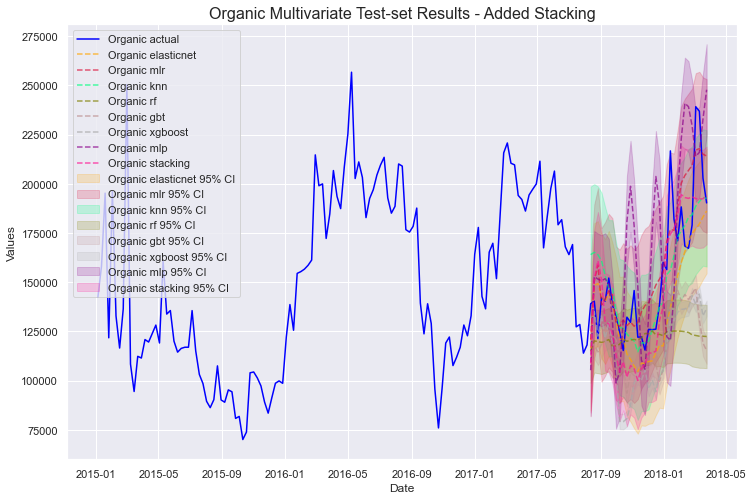

In [31]:
mvf.plot_test_set(series='Organic',put_best_on_top=True,ci=True)
plt.title('Organic Multivariate Test-set Results - Added Stacking',size=16)
plt.show()

In [36]:
mvf.set_best_model(determine_best_by='LevelTestSetMAPE')
results2 = mvf.export_model_summaries()
results2[
    [
        'ModelNickname',
        'Series',
        'LevelTestSetMAPE',
        'LevelTestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'Lags',
        'best_model'
    ]
]

,ModelNickname,Series,LevelTestSetMAPE,LevelTestSetR2,InSampleMAPE,InSampleR2,Lags,best_model
0,elasticnet,Conventional,0.1168,0.4077,0.0832,0.6262,13,True
1,mlr,Conventional,0.1518,0.3402,0.0992,0.4793,3,False
2,knn,Conventional,0.1711,0.2682,0.0985,0.5246,13,False
3,rf,Conventional,0.1805,0.0180,0.0476,0.9031,10,False
4,gbt,Conventional,0.1644,0.1984,0.0195,0.9862,10,False
5,xgboost,Conventional,0.1515,0.2215,0.0101,0.9960,13,False
6,mlp,Conventional,0.1899,-0.0016,0.0712,0.8127,10,False
7,stacking,Conventional,0.1388,0.3365,0.0935,0.5282,13,False
8,elasticnet,Organic,0.1185,0.3488,0.0843,0.8679,13,True
9,mlr,Organic,0.1011,0.6751,0.1010,0.7648,3,False


In [33]:
print('-'*100)
for series in results2['Series'].unique():
    print('multivariate average test MAPE for {}: {:.4f}'.format(series,results2.loc[results2['Series'] == series,'LevelTestSetMAPE'].mean()))
    print('multivariate average test R2 for {}: {:.2f}'.format(series,results2.loc[results2['Series'] == series,'LevelTestSetR2'].mean()))
    print('-'*100)

----------------------------------------------------------------------------------------------------
multivariate average test MAPE for Conventional: 0.1581
multivariate average test R2 for Conventional: 0.22
----------------------------------------------------------------------------------------------------
multivariate average test MAPE for Organic: 0.1607
multivariate average test R2 for Organic: -0.08
----------------------------------------------------------------------------------------------------


### Plot Final Forecasts

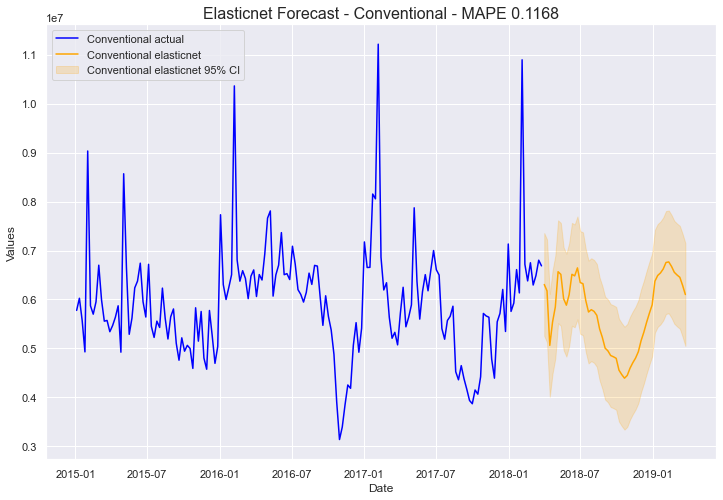

In [34]:
mvf.plot(series='Conventional',models='elasticnet',ci=True)
plt.title('Elasticnet Forecast - Conventional - MAPE 0.1168',size=16)
plt.show()

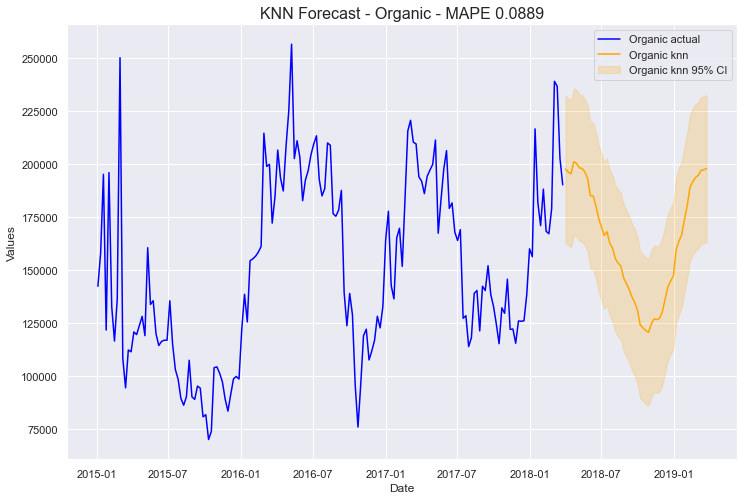

In [35]:
mvf.plot(series='Organic',models='knn',ci=True)
plt.title('KNN Forecast - Organic - MAPE 0.0889',size=16)
plt.show()

All-in-all, better results on the test-set were obtained by using the multivariate approach, both in terms of the models with the best error metrics and the average error metrics between all applied models. The Elasticnet was the best model for the conventional series, KNN for the organic.